Starting bilevel optimization to find optimal weights...
Note: Upper bounds set for channels: {'TV': 0.5, 'Online marketing': 0.5}
Channels 'Radio' and 'Other' excluded from analysis.
RUNNING THE L-BFGS-B CODE

           * * *



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.43308D+06    |proj g|=  5.00000D-01

Optimal weights found:
TV: Raw Weight = 0.193791, Normalized = 0.092538
Digital: Raw Weight = 0.001500, Normalized = 0.000716
Sponsorship: Raw Weight = 0.135039, Normalized = 0.064483
Content Marketing: Raw Weight = 0.042449, Normalized = 0.020270
Online marketing: Raw Weight = 0.816744, Normalized = 0.390008
Affiliates: Raw Weight = 0.876098, Normalized = 0.418350
SEM: Raw Weight = 0.028551, Normalized = 0.013634

Month: 2023-07 (Investment: ₹17.06)
TV:                  Allocation: ₹      1.02, Percentage:   5.96%, Raw Weight: 0.193791, Norm Weight: 0.092538
Digital:             Allocation: ₹      0.02, Percentage:   0.10%, Raw Weight: 0.001500, Norm Weight: 0.000716
Sponsorship:         Allocation: ₹      0.41, Percentage:   2.38%, Raw Weight: 0.135039, Norm Weight: 0.064483
Content Marketing:   Alloca

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:441: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:495: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_eq = vstack([con['jac'](x, *con['args'])
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:501: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_ieq = vstack([con['jac'](x, *con['args'])


Channel weights visualization saved as bilevel_channel_weights_constrained.png
Weight comparison visualization saved as weight_comparison_constrained.png
Starting bilevel optimization to find optimal weights...
Note: Upper bounds set for channels: {'TV': 0.5, 'Online marketing': 0.5}
Channels 'Radio' and 'Other' excluded from analysis.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.70509D+06    |proj g|=  5.00000D-01

Optimal weights found:
TV: Raw Weight = 0.139913, Normalized = 0.072313
Digital: Raw Weight = 0.018118, Normalized = 0.009364
Sponsorship: Raw Weight = 0.064307, Normalized = 0.033237
Content Marketing: Raw Weight = 0.116177, Normalized = 0.060045
Online marketing: Raw Weight = 0.764680, Normalized = 0.395218
Affiliates: Raw Weight = 0.748151, Normalized = 0.386675
SEM: Raw Weight = 0.083484, Normalized = 0.043148

Month: 2023-05 (Investment: ₹78.06)
TV:                  Allocation: ₹      5.13, Percentage:   6.58%, Raw Weight: 0.139913, Norm Weight: 0.072313
Digital:             Allocation: ₹      0.08, Percentage:   0.10%, Raw Weight: 0.018118, Norm Weight: 0.009364
Sponsorship:         Allocation: ₹      1.82, Percentage:   2.33%, Raw Weight: 0.064307, Norm

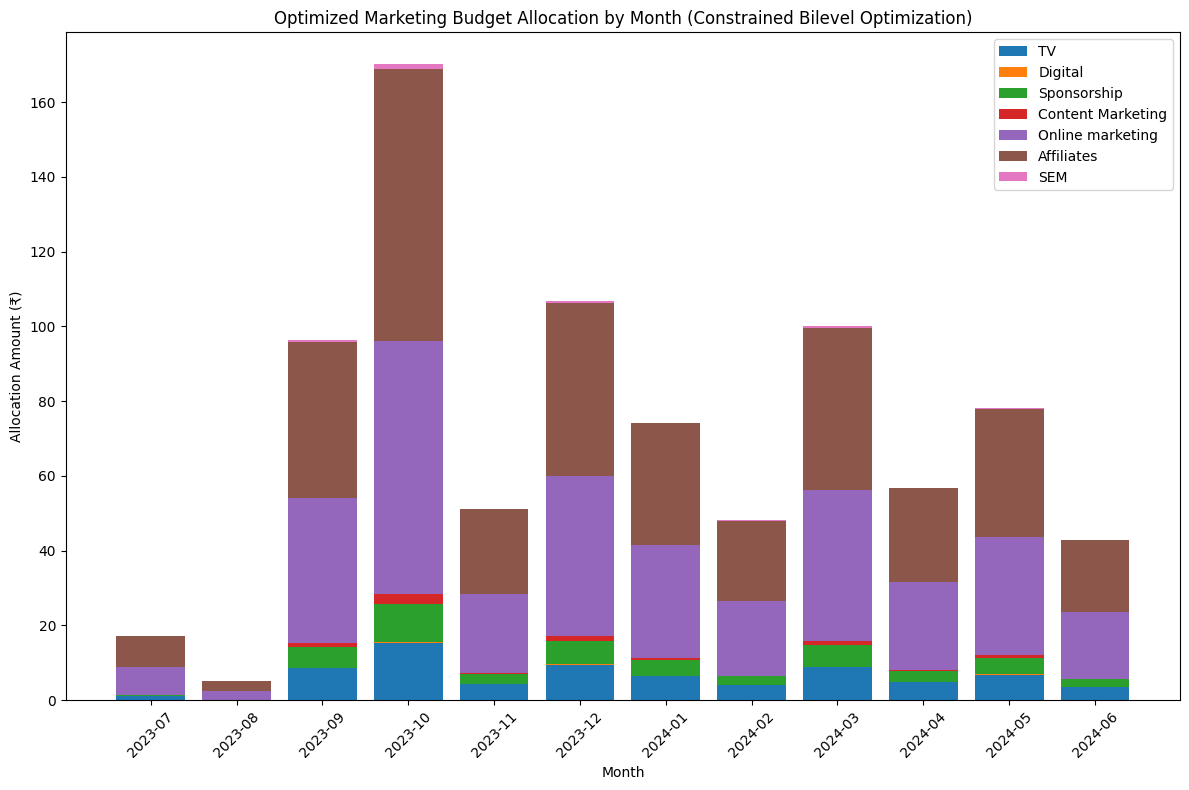

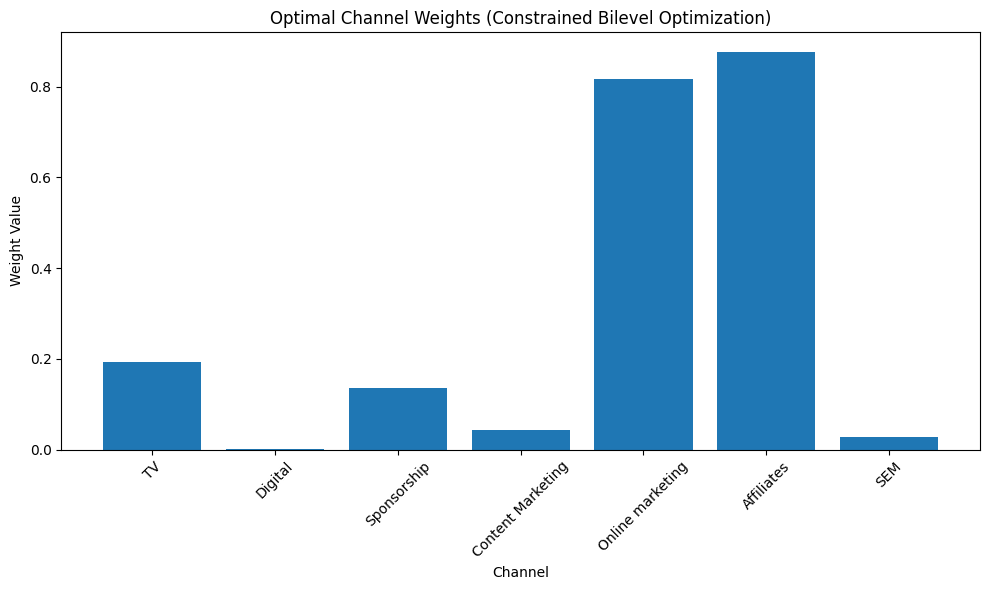

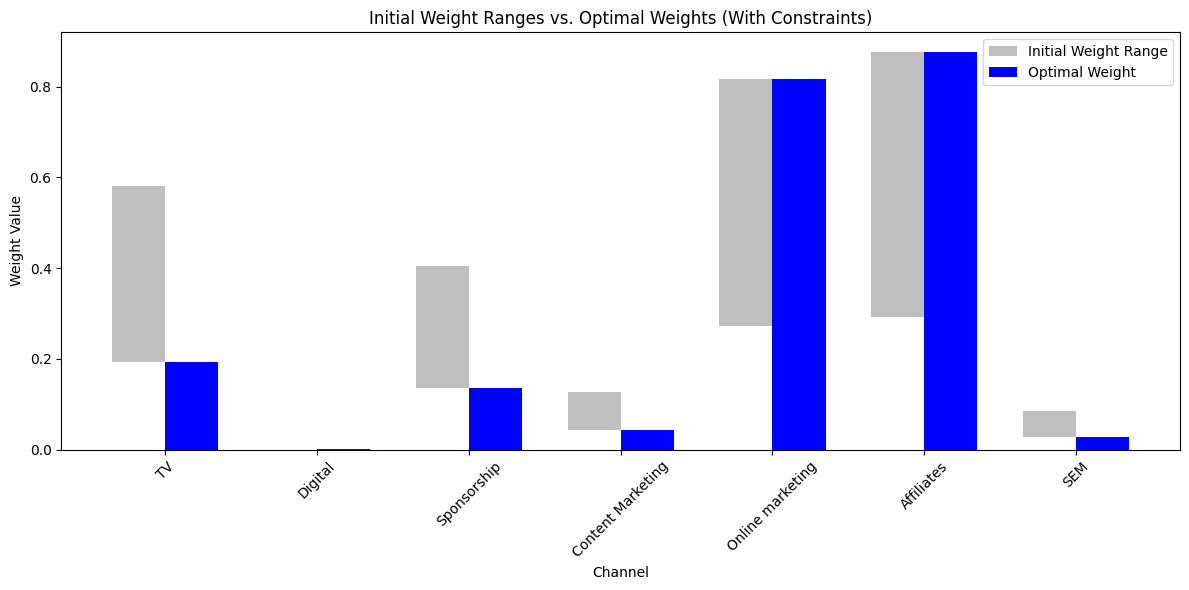

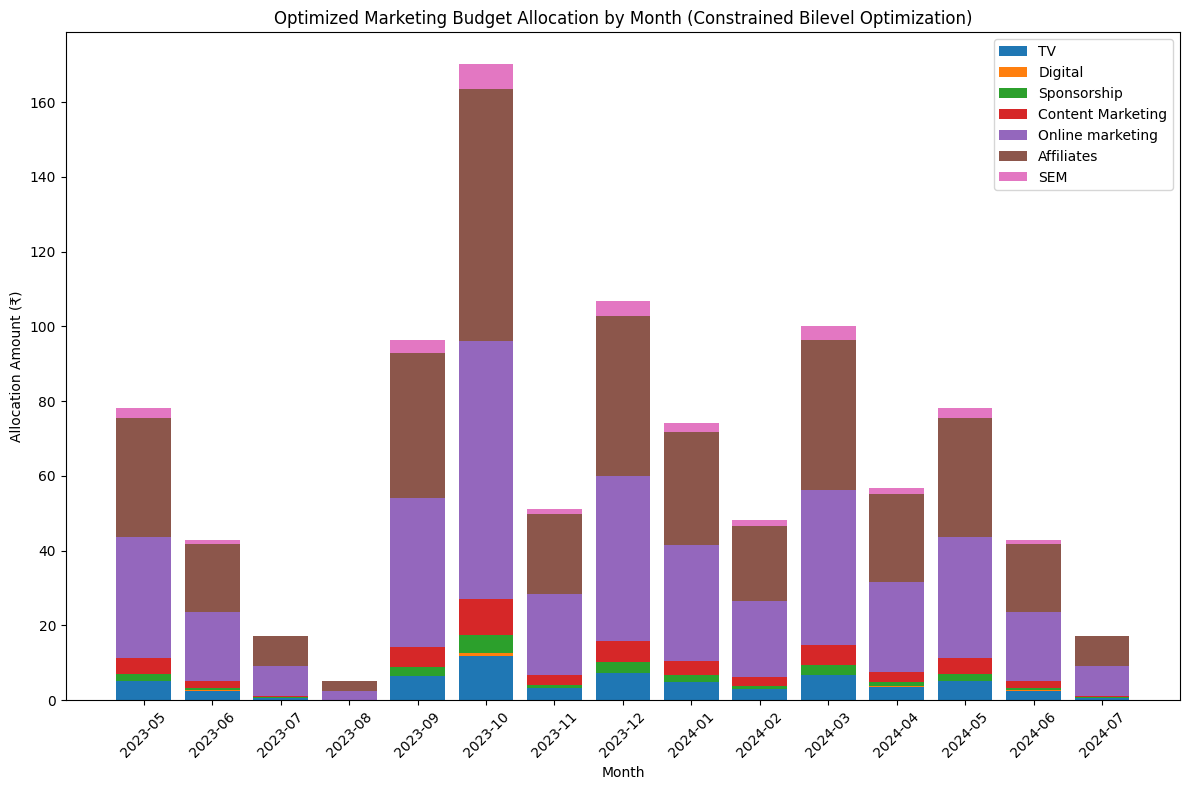

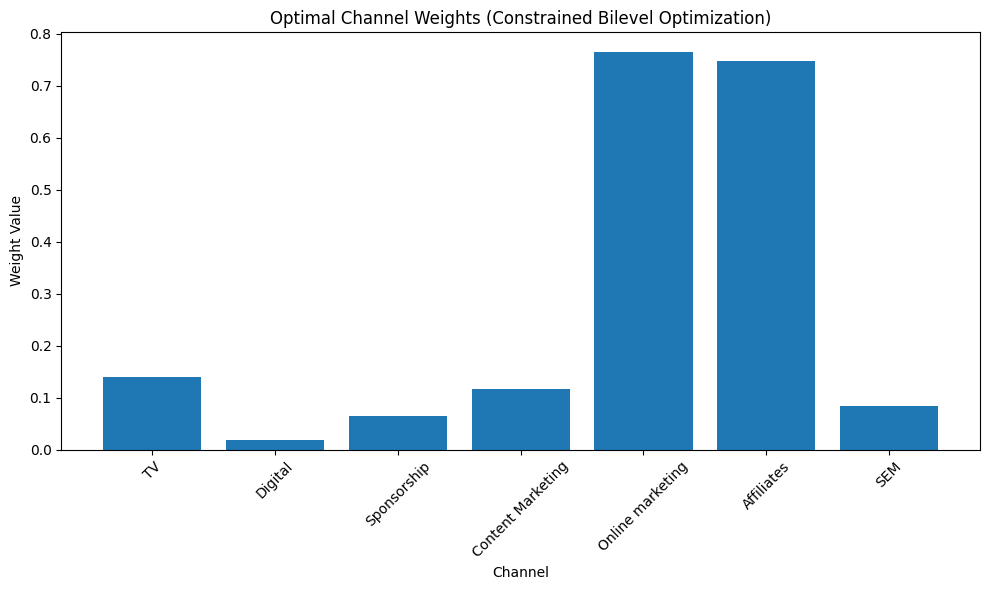

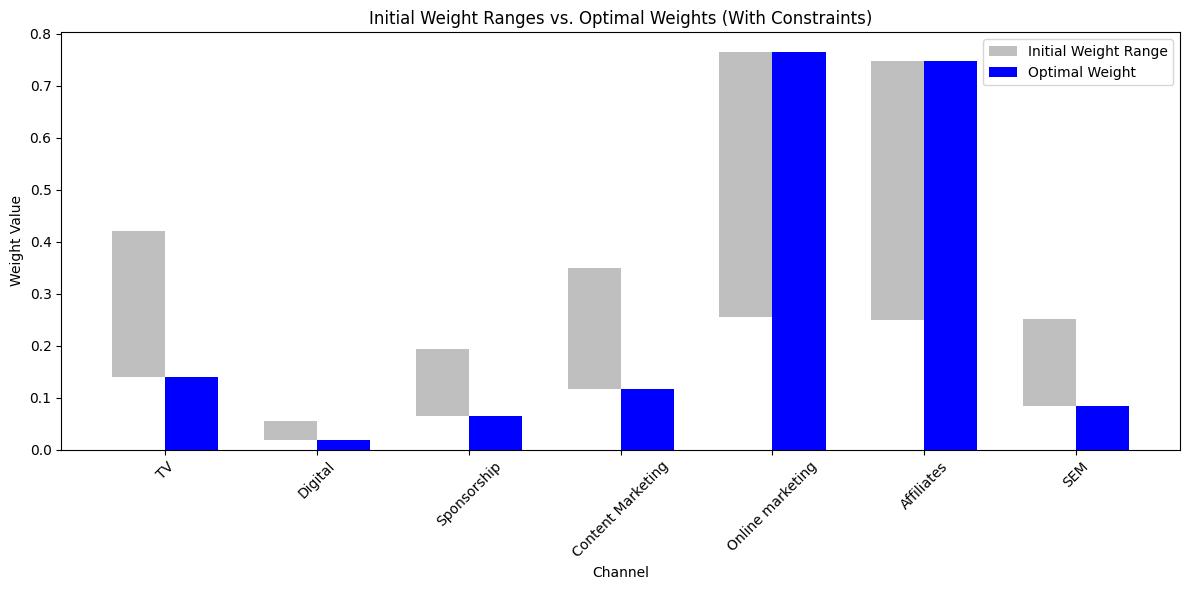

In [5]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import random

class BudgetOptimizer:
    def __init__(self, data_file="Final_monthly.csv", random_seed=42):
        # Configuration
        self.CHANNELS = ["TV", "Digital", "Sponsorship", "Content Marketing", 
                         "Online marketing", "Affiliates", "SEM"]  # Removed "Radio" and "Other"
        self.RANDOM_SEED = random_seed
        
        # Channels with upper bound constraints
        self.UPPER_BOUND_CHANNELS = {
            "TV": 0.5,  # 50% max allocation
            "Online marketing": 0.5  # 50% max allocation
        }
        
        # Set random seed for reproducibility
        np.random.seed(self.RANDOM_SEED)
        random.seed(self.RANDOM_SEED)
        
        # Data attributes
        self.data_file = data_file
        self.df = None
        self.existing_channels = []
        self.num_channels = 0
        self.total_investments = None
        self.gmv_values = None
        self.num_months = 0
        self.month_years = None
        self.channel_data = None
        self.channel_percentages = None
        self.avg_percentages = None
        self.weight_ranges = {}
        
        # Results
        self.optimal_weights = None
        self.normalized_weights = None
        self.results_df = None
        
    def prepare_data(self):
        """Load and prepare data for optimization"""
        self.df = pd.read_csv(self.data_file)
        self.df.columns = self.df.columns.str.strip()
        
        # Filter existing channels
        self.existing_channels = [col for col in self.CHANNELS if col in self.df.columns]
        self.num_channels = len(self.existing_channels)
        
        # Get total investments and GMV
        self.total_investments = self.df["Total Investment"].values
        self.gmv_values = self.df["gmv_next_minus_investment"].values if "gmv_next_minus_investment" in self.df.columns else None
        
        self.num_months = len(self.total_investments)
        
        # Extract month/year information for better reporting
        self.month_years = self.df["Month_Year"].values if "Month_Year" in self.df.columns else [f"Month {i+1}" for i in range(self.num_months)]
        
        # Analyze historical data to understand channel effectiveness
        self.channel_data = self.df[self.existing_channels].values
        self.channel_percentages = self.channel_data / np.sum(self.channel_data, axis=1)[:, np.newaxis]
        
        # Calculate historical average allocation percentages
        self.avg_percentages = np.mean(self.channel_percentages, axis=0)
        
        self._calculate_weight_ranges()
        
    def _calculate_weight_ranges(self):
        """Calculate correlation between channel investment and GMV to establish weight ranges"""
        if self.gmv_values is not None:
            for i, channel in enumerate(self.existing_channels):
                correlation = np.corrcoef(self.channel_data[:, i], self.gmv_values)[0, 1]
                base_weight = max(0.001, correlation)
                
                # Define a reasonable range around the correlation coefficient
                # Lower bound: 50% of base weight, Upper bound: 150% of base weight
                self.weight_ranges[channel] = (max(0.001, base_weight * 0.5), base_weight * 1.5)
        else:
            # If GMV not available, use equal effectiveness with wide ranges
            for channel in self.existing_channels:
                self.weight_ranges[channel] = (0.001, 2.0)
    
    def get_weights_from_params(self, weight_params):
        """Convert optimization parameters to channel weights"""
        weights = np.zeros(self.num_channels)
        for i, channel in enumerate(self.existing_channels):
            min_w, max_w = self.weight_ranges[channel]
            # Scale the parameter (0-1) to the weight range
            weights[i] = min_w + weight_params[i] * (max_w - min_w)
        return weights
    
    def lower_level_optimization(self, weights, month_idx, total_inv):
        """
        Find optimal allocations given a set of weights and total investment
        """
        def objective_function(allocations):
            """
            Maximize revenue based on allocations and effectiveness
            Revenue model: sum(w_i * log(x_i + 1))
            """
            # Ensure allocations are positive and sum to total investment
            allocations = np.abs(allocations)
            allocations = allocations / np.sum(allocations) * total_inv
            
            # Calculate revenue using log-based diminishing returns model
            revenue = np.sum(weights * np.log(allocations + 1))
            
            # We minimize the negative revenue
            return -revenue
        
        def constraint_sum(allocations):
            """Constraint: Sum of allocations should equal 1 (will be scaled later)"""
            return np.sum(allocations) - 1.0
        
        # Create constraints for TV and Online marketing upper bounds
        constraints = [{'type': 'eq', 'fun': constraint_sum}]
        
        # Add upper bound constraints for specific channels
        for channel_name, upper_bound in self.UPPER_BOUND_CHANNELS.items():
            if channel_name in self.existing_channels:
                channel_idx = self.existing_channels.index(channel_name)
                
                # Create a constraint function for this channel's upper bound
                def channel_upper_bound(allocations, idx=channel_idx, bound=upper_bound):
                    """Constraint: Channel allocation should not exceed the upper bound"""
                    return bound - allocations[idx]
                
                constraints.append({
                    'type': 'ineq',
                    'fun': channel_upper_bound
                })
        
        # Initial guess: use historical averages or equal allocation
        initial_guess = self.avg_percentages if len(self.avg_percentages) > 0 else np.ones(self.num_channels) / self.num_channels
        
        # Bounds: ensure all allocations are positive (0 to 100%)
        bounds = [(0.001, 1.0) for _ in range(self.num_channels)]
        
        # Optimize
        result = minimize(
            objective_function,
            initial_guess,
            method='SLSQP',
            bounds=bounds,
            constraints=constraints,
            options={'disp': False, 'maxiter': 1000}
        )
        
        # Scale optimized percentages to total investment
        opt_percentages = result.x / np.sum(result.x)
        opt_allocations = opt_percentages * total_inv
        revenue = -result.fun
        
        return opt_percentages, opt_allocations, revenue
    
    def upper_level_objective(self, weight_params):
        """
        Objective function for the upper-level optimization.
        Find weights that maximize predictive performance across all months.
        """
        # Convert parameters to weights
        weights = self.get_weights_from_params(weight_params)
        
        # Variable to store performance metric
        total_prediction_error = 0
        predicted_gmvs = []
        
        # Calculate allocations and predicted GMV for each month
        for month_idx in range(self.num_months - 1):  # Use all but last month for training
            total_inv = self.total_investments[month_idx]
            
            # Get optimal allocations for these weights
            _, allocations, predicted_revenue = self.lower_level_optimization(weights, month_idx, total_inv)
            
            # Store predicted revenue as proxy for GMV
            predicted_gmvs.append(predicted_revenue)
        
        # Calculate error between predicted and actual GMV trend
        if self.gmv_values is not None:
            # Scale predicted revenues to match the scale of GMV
            scaling_factor = np.mean(self.gmv_values[:-1]) / np.mean(predicted_gmvs) if np.mean(predicted_gmvs) > 0 else 1
            scaled_predictions = np.array(predicted_gmvs) * scaling_factor
            
            # Calculate error between scaled predictions and actual GMV
            errors = scaled_predictions - self.gmv_values[:-1]
            total_prediction_error = np.sum(errors**2)  # Sum of squared errors
        else:
            # If no GMV data, optimize for maximum predicted revenue
            total_prediction_error = -np.sum(predicted_gmvs)
        
        return total_prediction_error
    
    def run_bilevel_optimization(self):
        """
        Run the bilevel optimization to find optimal weights and allocations
        """
        print("Starting bilevel optimization to find optimal weights...")
        print(f"Note: Upper bounds set for channels: {self.UPPER_BOUND_CHANNELS}")
        print(f"Channels 'Radio' and 'Other' excluded from analysis.")
        
        # Initial guess for weight parameters (scaled to 0-1 range)
        initial_weight_params = np.ones(self.num_channels) * 0.5  # Start in the middle of each range
        
        # Bounds for weight parameters (0-1, will be scaled to actual weight ranges)
        weight_bounds = [(0, 1) for _ in range(self.num_channels)]
        
        # Optimize weights
        upper_result = minimize(
            self.upper_level_objective,
            initial_weight_params,
            method='L-BFGS-B',  # Different method more suited for upper level
            bounds=weight_bounds,
            options={'disp': True, 'maxiter': 100}
        )
        
        # Get optimal weights
        optimal_weight_params = upper_result.x
        self.optimal_weights = self.get_weights_from_params(optimal_weight_params)
        
        # Normalize weights for reporting
        self.normalized_weights = self.optimal_weights / np.sum(self.optimal_weights)
        
        print("\nOptimal weights found:")
        for i, channel in enumerate(self.existing_channels):
            print(f"{channel}: Raw Weight = {self.optimal_weights[i]:.6f}, Normalized = {self.normalized_weights[i]:.6f}")
        
        return self.optimal_weights, self.normalized_weights
    
    def generate_allocation_recommendations(self):
        """Process each month with optimal weights to generate final allocation recommendations"""
        if self.optimal_weights is None or self.normalized_weights is None:
            print("Error: Must run bilevel optimization first")
            return None
            
        all_results = []
        for month_idx in range(self.num_months):
            total_inv = self.total_investments[month_idx]
            month_year = self.month_years[month_idx]
            
            # Optimize allocations using the optimal weights
            percentages, allocations, revenue = self.lower_level_optimization(
                self.optimal_weights, month_idx, total_inv
            )
            
            # Store results
            month_result = {
                'Month': month_year,
                'Total_Investment': total_inv,
                'Projected_Revenue': revenue
            }
            
            # Add channel allocations
            for i, channel in enumerate(self.existing_channels):
                month_result[f'{channel}_Allocation'] = allocations[i]
                month_result[f'{channel}_Percentage'] = percentages[i] * 100
                month_result[f'{channel}_Raw_Weight'] = self.optimal_weights[i]
                month_result[f'{channel}_Normalized_Weight'] = self.normalized_weights[i]
            
            all_results.append(month_result)
            
            # Print formatted results
            print(f"\nMonth: {month_year} (Investment: ₹{total_inv:,.2f})")
            for i, channel in enumerate(self.existing_channels):
                print(f"{channel+':':<20} Allocation: ₹{allocations[i]:>10,.2f}, "
                      f"Percentage: {percentages[i]*100:>6.2f}%, "
                      f"Raw Weight: {self.optimal_weights[i]:>8.6f}, "
                      f"Norm Weight: {self.normalized_weights[i]:>8.6f}")
            print(f"Projected Revenue Value: {revenue:,.2f}")
        
        # Create a DataFrame with all results
        self.results_df = pd.DataFrame(all_results)
        return self.results_df
    
    def save_results(self, output_file="bilevel_optimization_results_constrained.csv"):
        """Save optimization results to CSV"""
        if self.results_df is None:
            print("Error: No results to save. Run generate_allocation_recommendations first.")
            return
            
        self.results_df.to_csv(output_file, index=False)
        print(f"\nResults saved to {output_file}")
        
    def visualize_allocations(self, filename="bilevel_budget_allocation_constrained.png"):
        """Generate visualization of the allocation"""
        if self.results_df is None:
            print("Error: No results to visualize. Run generate_allocation_recommendations first.")
            return
            
        plt.figure(figsize=(12, 8))
        
        # Prepare data for stacked bar chart
        month_labels = self.results_df['Month'].values
        allocation_data = {channel: self.results_df[f'{channel}_Allocation'].values 
                          for channel in self.existing_channels}
        
        # Create stacked bar chart
        bottom = np.zeros(self.num_months)
        for channel in self.existing_channels:
            plt.bar(month_labels, allocation_data[channel], bottom=bottom, label=channel)
            bottom += allocation_data[channel]
        
        plt.title('Optimized Marketing Budget Allocation by Month (Constrained Bilevel Optimization)')
        plt.xlabel('Month')
        plt.ylabel('Allocation Amount (₹)')
        plt.legend(loc='upper right')
        plt.xticks(rotation=45)
        plt.tight_layout()
        
        # Save plot
        plt.savefig(filename)
        print(f"Visualization saved as {filename}")
        
    def visualize_weights(self, filename="bilevel_channel_weights_constrained.png"):
        """Create a visualization for weights"""
        if self.optimal_weights is None:
            print("Error: No weights to visualize. Run bilevel optimization first.")
            return
            
        plt.figure(figsize=(10, 6))
        
        # Plot bar chart of channel weights
        plt.bar(self.existing_channels, self.optimal_weights)
        plt.title('Optimal Channel Weights (Constrained Bilevel Optimization)')
        plt.xlabel('Channel')
        plt.ylabel('Weight Value')
        plt.xticks(rotation=45)
        plt.tight_layout()
        
        # Save weight plot
        plt.savefig(filename)
        print(f"Channel weights visualization saved as {filename}")
        
    def visualize_weight_comparison(self, filename="weight_comparison_constrained.png"):
        """Create visualization comparing initial weight ranges and optimal weights"""
        if self.optimal_weights is None or not self.weight_ranges:
            print("Error: Missing data for visualization. Run bilevel optimization first.")
            return
            
        plt.figure(figsize=(12, 6))
        
        # Width of the bars
        bar_width = 0.35
        
        # Positions for the bars
        index = np.arange(self.num_channels)
        
        # Plot initial weight ranges
        lower_bounds = np.array([self.weight_ranges[ch][0] for ch in self.existing_channels])
        upper_bounds = np.array([self.weight_ranges[ch][1] for ch in self.existing_channels])
        
        # Plot bars for weight ranges
        plt.bar(index, upper_bounds - lower_bounds, bar_width, bottom=lower_bounds, alpha=0.5, 
                color='gray', label='Initial Weight Range')
        
        # Plot markers for optimal weights
        plt.bar(index + bar_width, self.optimal_weights, bar_width, color='blue', 
                label='Optimal Weight')
        
        plt.xlabel('Channel')
        plt.ylabel('Weight Value')
        plt.title('Initial Weight Ranges vs. Optimal Weights (With Constraints)')
        plt.xticks(index + bar_width/2, self.existing_channels, rotation=45)
        plt.legend()
        plt.tight_layout()
        
        # Save comparison plot
        plt.savefig(filename)
        print(f"Weight comparison visualization saved as {filename}")
        
    def optimize(self):
        """Run the complete optimization process"""
        self.prepare_data()
        self.run_bilevel_optimization()
        self.generate_allocation_recommendations()
        self.save_results()
        self.visualize_allocations()
        self.visualize_weights()
        self.visualize_weight_comparison()
        



import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import random

class BudgetOptimiserGMV:
    def __init__(self, data_file="Monthly_updated.csv", random_seed=42):
        # Configuration
        self.CHANNELS = ["TV", "Digital", "Sponsorship", "Content Marketing", 
                        "Online marketing", "Affiliates", "SEM"]  # Removed "Radio" and "Other"
        self.RANDOM_SEED = random_seed
        
        # Channels with upper bound constraints
        self.UPPER_BOUND_CHANNELS = {
            "TV": 0.5,  # 50% max allocation
            "Online marketing": 0.5  # 50% max allocation
        }
        
        # Set random seed for reproducibility
        np.random.seed(self.RANDOM_SEED)
        random.seed(self.RANDOM_SEED)
        
        # Data attributes
        self.data_file = data_file
        self.df = None
        self.existing_channels = []
        self.num_channels = 0
        self.total_investments = None
        self.gmv_values = None
        self.num_months = 0
        self.month_years = None
        self.channel_data = None
        self.channel_percentages = None
        self.avg_percentages = None
        self.weight_ranges = {}
        
        # Results
        self.optimal_weights = None
        self.normalized_weights = None
        self.results_df = None
        
    def load_data(self):
        """Load and prepare data for optimization"""
        self.df = pd.read_csv(self.data_file)
        self.df.columns = self.df.columns.str.strip()
        
        # Filter existing channels
        self.existing_channels = [col for col in self.CHANNELS if col in self.df.columns]
        self.num_channels = len(self.existing_channels)
        
        # Get total investments and GMV
        self.total_investments = self.df["Total Investment"].values
        self.gmv_values = self.df["gmv"].values if "gmv" in self.df.columns else None
        
        self.num_months = len(self.total_investments)
        
        # Extract month/year information for better reporting
        self.month_years = self.df["Month_Year"].values if "Month_Year" in self.df.columns else [f"Month {i+1}" for i in range(self.num_months)]
        
        # Analyze historical data to understand channel effectiveness
        self.channel_data = self.df[self.existing_channels].values
        self.channel_percentages = self.channel_data / np.sum(self.channel_data, axis=1)[:, np.newaxis]
        
        # Calculate historical average allocation percentages
        self.avg_percentages = np.mean(self.channel_percentages, axis=0)
        
        self._calculate_weight_ranges()
        
    def _calculate_weight_ranges(self):
        """Calculate correlation between channel investment and GMV to establish weight ranges"""
        if self.gmv_values is not None:
            for i, channel in enumerate(self.existing_channels):
                correlation = np.corrcoef(self.channel_data[:, i], self.gmv_values)[0, 1]
                base_weight = max(0.001, correlation)
                
                # Define a reasonable range around the correlation coefficient
                # Lower bound: 50% of base weight, Upper bound: 150% of base weight
                self.weight_ranges[channel] = (max(0.001, base_weight * 0.5), base_weight * 1.5)
        else:
            # If GMV not available, use equal effectiveness with wide ranges
            for channel in self.existing_channels:
                self.weight_ranges[channel] = (0.001, 2.0)
    
    def get_weights_from_params(self, weight_params):
        """Convert optimization parameters to channel weights"""
        weights = np.zeros(self.num_channels)
        for i, channel in enumerate(self.existing_channels):
            min_w, max_w = self.weight_ranges[channel]
            # Scale the parameter (0-1) to the weight range
            weights[i] = min_w + weight_params[i] * (max_w - min_w)
        return weights
    
    def lower_level_optimization(self, weights, month_idx, total_inv):
        """
        Find optimal allocations given a set of weights and total investment
        """
        def objective_function(allocations):
            """
            Maximize revenue based on allocations and effectiveness
            Revenue model: sum(w_i * log(x_i + 1))
            """
            # Ensure allocations are positive and sum to total investment
            allocations = np.abs(allocations)
            allocations = allocations / np.sum(allocations) * total_inv
            
            # Calculate revenue using log-based diminishing returns model
            revenue = np.sum(weights * np.log(allocations + 1))
            
            # We minimize the negative revenue
            return -revenue
        
        def constraint_sum(allocations):
            """Constraint: Sum of allocations should equal 1 (will be scaled later)"""
            return np.sum(allocations) - 1.0
        
        # Create constraints for TV and Online marketing upper bounds
        constraints = [{'type': 'eq', 'fun': constraint_sum}]
        
        # Add upper bound constraints for specific channels
        for channel_name, upper_bound in self.UPPER_BOUND_CHANNELS.items():
            if channel_name in self.existing_channels:
                channel_idx = self.existing_channels.index(channel_name)
                
                # Create a constraint function for this channel's upper bound
                def channel_upper_bound(allocations, idx=channel_idx, bound=upper_bound):
                    """Constraint: Channel allocation should not exceed the upper bound"""
                    return bound - allocations[idx]
                
                constraints.append({
                    'type': 'ineq',
                    'fun': channel_upper_bound
                })
        
        # Initial guess: use historical averages or equal allocation
        initial_guess = self.avg_percentages if len(self.avg_percentages) > 0 else np.ones(self.num_channels) / self.num_channels
        
        # Bounds: ensure all allocations are positive (0 to 100%)
        bounds = [(0.001, 1.0) for _ in range(self.num_channels)]
        
        # Optimize
        result = minimize(
            objective_function,
            initial_guess,
            method='SLSQP',
            bounds=bounds,
            constraints=constraints,
            options={'disp': False, 'maxiter': 1000}
        )
        
        # Scale optimized percentages to total investment
        opt_percentages = result.x / np.sum(result.x)
        opt_allocations = opt_percentages * total_inv
        revenue = -result.fun
        
        return opt_percentages, opt_allocations, revenue
    
    def upper_level_objective(self, weight_params):
        """
        Objective function for the upper-level optimization.
        Find weights that maximize predictive performance across all months.
        """
        # Convert parameters to weights
        weights = self.get_weights_from_params(weight_params)
        
        # Variable to store performance metric
        total_prediction_error = 0
        predicted_gmvs = []
        
        # Calculate allocations and predicted GMV for each month
        for month_idx in range(self.num_months - 1):  # Use all but last month for training
            total_inv = self.total_investments[month_idx]
            
            # Get optimal allocations for these weights
            _, allocations, predicted_revenue = self.lower_level_optimization(weights, month_idx, total_inv)
            
            # Store predicted revenue as proxy for GMV
            predicted_gmvs.append(predicted_revenue)
        
        # Calculate error between predicted and actual GMV trend
        if self.gmv_values is not None:
            # Scale predicted revenues to match the scale of GMV
            scaling_factor = np.mean(self.gmv_values[:-1]) / np.mean(predicted_gmvs) if np.mean(predicted_gmvs) > 0 else 1
            scaled_predictions = np.array(predicted_gmvs) * scaling_factor
            
            # Calculate error between scaled predictions and actual GMV
            errors = scaled_predictions - self.gmv_values[:-1]
            total_prediction_error = np.sum(errors**2)  # Sum of squared errors
        else:
            # If no GMV data, optimize for maximum predicted revenue
            total_prediction_error = -np.sum(predicted_gmvs)
        
        return total_prediction_error
    
    def run_bilevel_optimization(self):
        """
        Run the bilevel optimization to find optimal weights and allocations
        """
        print("Starting bilevel optimization to find optimal weights...")
        print(f"Note: Upper bounds set for channels: {self.UPPER_BOUND_CHANNELS}")
        print(f"Channels 'Radio' and 'Other' excluded from analysis.")
        
        # Initial guess for weight parameters (scaled to 0-1 range)
        initial_weight_params = np.ones(self.num_channels) * 0.5  # Start in the middle of each range
        
        # Bounds for weight parameters (0-1, will be scaled to actual weight ranges)
        weight_bounds = [(0, 1) for _ in range(self.num_channels)]
        
        # Optimize weights
        upper_result = minimize(
            self.upper_level_objective,
            initial_weight_params,
            method='L-BFGS-B',  # Different method more suited for upper level
            bounds=weight_bounds,
            options={'disp': True, 'maxiter': 100}
        )
        
        # Get optimal weights
        optimal_weight_params = upper_result.x
        self.optimal_weights = self.get_weights_from_params(optimal_weight_params)
        
        # Normalize weights for reporting
        self.normalized_weights = self.optimal_weights / np.sum(self.optimal_weights)
        
        print("\nOptimal weights found:")
        for i, channel in enumerate(self.existing_channels):
            print(f"{channel}: Raw Weight = {self.optimal_weights[i]:.6f}, Normalized = {self.normalized_weights[i]:.6f}")
        
        return self.optimal_weights, self.normalized_weights
    
    def generate_allocation_recommendations(self):
        """Process each month with optimal weights to generate final allocation recommendations"""
        if self.optimal_weights is None or self.normalized_weights is None:
            print("Error: Must run bilevel optimization first")
            return None
            
        all_results = []
        for month_idx in range(self.num_months):
            total_inv = self.total_investments[month_idx]
            month_year = self.month_years[month_idx]
            
            # Optimize allocations using the optimal weights
            percentages, allocations, revenue = self.lower_level_optimization(
                self.optimal_weights, month_idx, total_inv
            )
            
            # Store results
            month_result = {
                'Month': month_year,
                'Total_Investment': total_inv,
                'Projected_Revenue': revenue
            }
            
            # Add channel allocations
            for i, channel in enumerate(self.existing_channels):
                month_result[f'{channel}_Allocation'] = allocations[i]
                month_result[f'{channel}_Percentage'] = percentages[i] * 100
                month_result[f'{channel}_Raw_Weight'] = self.optimal_weights[i]
                month_result[f'{channel}_Normalized_Weight'] = self.normalized_weights[i]
            
            all_results.append(month_result)
            
            # Print formatted results
            print(f"\nMonth: {month_year} (Investment: ₹{total_inv:,.2f})")
            for i, channel in enumerate(self.existing_channels):
                print(f"{channel+':':<20} Allocation: ₹{allocations[i]:>10,.2f}, "
                      f"Percentage: {percentages[i]*100:>6.2f}%, "
                      f"Raw Weight: {self.optimal_weights[i]:>8.6f}, "
                      f"Norm Weight: {self.normalized_weights[i]:>8.6f}")
            print(f"Projected Revenue Value: {revenue:,.2f}")
        
        # Create a DataFrame with all results
        self.results_df = pd.DataFrame(all_results)
        
        # Save results to CSV
        self.results_df.to_csv("bilevel_optimization_results_constrained.csv", index=False)
        print("\nResults saved to bilevel_optimization_results_constrained.csv")
        
        return self.results_df
    
    def visualize_allocations(self):
        """Generate visualization of the allocation"""
        if self.results_df is None:
            print("Error: No results to visualize. Run generate_allocation_recommendations first.")
            return
            
        plt.figure(figsize=(12, 8))
        
        # Prepare data for stacked bar chart
        month_labels = self.results_df['Month'].values
        allocation_data = {channel: self.results_df[f'{channel}_Allocation'].values 
                          for channel in self.existing_channels}
        
        # Create stacked bar chart
        bottom = np.zeros(self.num_months)
        for channel in self.existing_channels:
            plt.bar(month_labels, allocation_data[channel], bottom=bottom, label=channel)
            bottom += allocation_data[channel]
        
        plt.title('Optimized Marketing Budget Allocation by Month (Constrained Bilevel Optimization)')
        plt.xlabel('Month')
        plt.ylabel('Allocation Amount (₹)')
        plt.legend(loc='upper right')
        plt.xticks(rotation=45)
        plt.tight_layout()
        
        # Save plot
        plt.savefig('bilevel_budget_allocation_constrained.png')
        print("Visualization saved as bilevel_budget_allocation_constrained.png")
        
    def visualize_weights(self):
        """Create a visualization for weights"""
        if self.optimal_weights is None:
            print("Error: No weights to visualize. Run bilevel optimization first.")
            return
            
        plt.figure(figsize=(10, 6))
        
        # Plot bar chart of channel weights
        plt.bar(self.existing_channels, self.optimal_weights)
        plt.title('Optimal Channel Weights (Constrained Bilevel Optimization)')
        plt.xlabel('Channel')
        plt.ylabel('Weight Value')
        plt.xticks(rotation=45)
        plt.tight_layout()
        
        # Save weight plot
        plt.savefig('bilevel_channel_weights_constrained.png')
        print("Channel weights visualization saved as bilevel_channel_weights_constrained.png")
        
    def visualize_weight_comparison(self):
        """Create visualization comparing initial weight ranges and optimal weights"""
        if self.optimal_weights is None or not self.weight_ranges:
            print("Error: Missing data for visualization. Run bilevel optimization first.")
            return
            
        plt.figure(figsize=(12, 6))
        
        # Width of the bars
        bar_width = 0.35
        
        # Positions for the bars
        index = np.arange(self.num_channels)
        
        # Plot initial weight ranges
        lower_bounds = np.array([self.weight_ranges[ch][0] for ch in self.existing_channels])
        upper_bounds = np.array([self.weight_ranges[ch][1] for ch in self.existing_channels])
        
        # Plot bars for weight ranges
        plt.bar(index, upper_bounds - lower_bounds, bar_width, bottom=lower_bounds, alpha=0.5, 
                color='gray', label='Initial Weight Range')
        
        # Plot markers for optimal weights
        plt.bar(index + bar_width, self.optimal_weights, bar_width, color='blue', 
                label='Optimal Weight')
        
        plt.xlabel('Channel')
        plt.ylabel('Weight Value')
        plt.title('Initial Weight Ranges vs. Optimal Weights (With Constraints)')
        plt.xticks(index + bar_width/2, self.existing_channels, rotation=45)
        plt.legend()
        plt.tight_layout()
        
        # Save comparison plot
        plt.savefig('weight_comparison_constrained.png')
        print("Weight comparison visualization saved as weight_comparison_constrained.png")
        
    def optimize(self):
        """Run the complete optimization process"""
        self.load_data()
        self.run_bilevel_optimization()
        self.generate_allocation_recommendations()
        self.visualize_allocations()
        self.visualize_weights()
        self.visualize_weight_comparison()
        

def main():
    # Example of preprocessing data (if needed)
    # Uncomment if you want to run this preprocessing step
    
    df = pd.read_csv("CSV Input Files/Monthly_updated.csv")
    df['Next_Month_GMV'] = df['gmv'].shift(-1)
    df['gmv_next_minus_investment'] = df['Next_Month_GMV'] - df['Total Investment']
    df.drop(columns=['Next_Month_GMV'], inplace=True)
    df = df.iloc[2:-1]  # Removes the first two rows and the last row
    # Reset index if needed
    df.reset_index(drop=True, inplace=True)
    df.to_csv("Final_monthly.csv")
    
    
    # Create optimizer and run full optimization
    optimizer = BudgetOptimizer(data_file="CSV Input Files/Final_monthly.csv")
    optimizer1 = BudgetOptimiserGMV(data_file="CSV Input Files/Monthly_updated.csv")
    optimizer.optimize()
    optimizer1.optimize()


if __name__ == "__main__":
    main()